<a href="https://colab.research.google.com/github/dhtm/MLBasics/blob/master/Sales_Campaign_classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegressionCV
%matplotlib inline

# Preprocessing
- Load data
- Drop columns
- Remove rows which are missing labels.
- One-hot encode categorical columns.

In [0]:
data = pd.read_csv('cleaned_data.csv')
data = data.drop(columns=['campaign_name', 'io_description', 'launch'])
data = data.dropna(subset=['is_launch', 'is_connect'])
for col in ['tweet_format', 'objective', 'vertical']:
    data = pd.get_dummies(data, columns=[col], prefix=col, drop_first=True)
data = data.fillna("")
print(data)

      campaign_length  daily_budget  \
0                  15       3000.00   
1                   9       6236.00   
2                   9       6236.00   
3                   4       4000.00   
4                  28       3316.00   
5                  28       3315.00   
6                  24       3093.00   
7                   8       2800.00   
8                   9        600.00   
9                   8       2800.00   
10                 19        704.24   
11                 34       4000.00   
12                  1       3711.35   
13                  4       4000.00   
14                 13       4700.00   
15                 28       8300.00   
16                  1       3085.37   
17                  1       1956.09   
18                  1       3742.65   
19                 15       3750.00   
20                  1       8937.00   
21                  1      54000.00   
22                 15       1500.00   
23                 26       1800.00   
24                 27    

# EDA
- Graph numeric columns to see if distribution is gaussian.
    - Since distribution is non-gaussian, use MinMax scaling instead of Standard scaling.

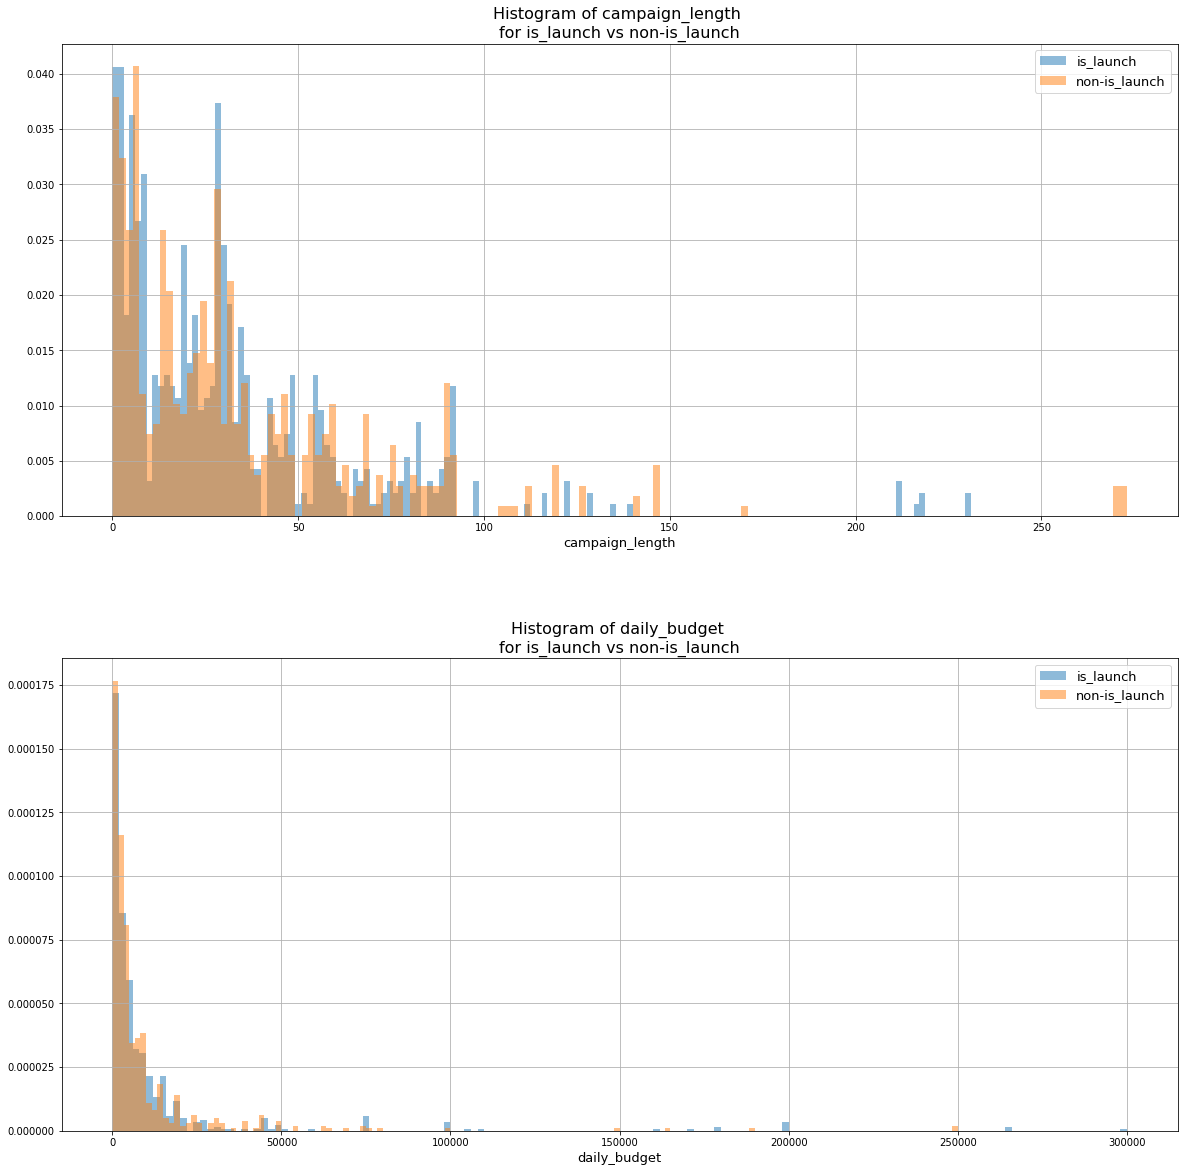

In [0]:
def graph_distributions(data, mask_target, graph_cols, target_cols = ['is_launch', 'is_connect']):
    mask = data[mask_target] == 1.0
    cols = set(graph_cols)# - set(target_cols + suppress_cols)
    fig, ax = plt.subplots(len(cols), 1, figsize = (20, 10*len(graph_cols)))
    for i, col in enumerate(cols):
        data[mask].hist(column=col, ax=ax[i], density=True, 
                                   label=mask_target, bins=150, alpha=0.5)
        data[~mask].hist(column=col, ax=ax[i], density=True,
                                    label=f'non-{mask_target}', bins=150, alpha=0.5)
        ax[i].set_title(f'Histogram of {col} \nfor {mask_target} vs non-{mask_target}', fontsize = 16)
        ax[i].set_xlabel(col, fontsize = 13)
        ax[i].legend(fontsize = 13)

graph_distributions(data, 'is_launch', ['campaign_length', 'daily_budget'])

In [0]:
data.groupby('is_launch').mean()

,campaign_length,daily_budget,is_connect,tweet_format_broadcast,tweet_format_image_conversation,tweet_format_image_direct_message,tweet_format_live_event,tweet_format_live_video,tweet_format_moment,tweet_format_none,...,vertical_catalyst_west,vertical_cpg,vertical_financial_services,vertical_health,vertical_m_e,vertical_not_verticalized,vertical_pac,vertical_retail,vertical_tech_telco,vertical_travel_mobile
is_launch,,,,,,,,,,,,,,,,,,,,,
0.0,35.148148,9444.479461,0.425926,0.001684,0.016835,0.000000,0.001684,0.000000,0.006734,0.052189,...,0.000000,0.230640,0.129630,0.020202,0.050505,0.000000,0.000000,0.065657,0.279461,0.015152
1.0,32.636513,12187.213651,0.279605,0.000000,0.004934,0.001645,0.001645,0.006579,0.009868,0.023026,...,0.004934,0.080592,0.075658,0.024671,0.125000,0.008224,0.024671,0.057566,0.375000,0.016447


## Create scaled dataset

In [0]:
from sklearn.preprocessing import MinMaxScaler
def get_train_test(data, target_cols, suppress_cols = []):
    from sklearn.model_selection import train_test_split
    cols = set(data.columns) - set(target_cols + suppress_cols)
    X = data[list(cols)]
    y = data[target_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    return {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

def scale_data(data_dict, columns = None):
    train = data_dict['X_train']
    columns = train.columns if columns is None else columns
    scaler = MinMaxScaler().fit(train[columns])
    scale_train = data_dict['X_train'].copy(deep=True)
    scale_train[columns] = scaler.transform(train[columns])
    scale_test = data_dict['X_test'].copy(deep=True)
    scale_test[columns] = scaler.transform(data_dict['X_test'][columns])

    scaled_data = data_dict.copy()
    scaled_data['X_train'] = scale_train
    scaled_data['X_test'] = scale_test
    return scaled_data

## Run baseline Logistic Regression (non-text features)

/Users/asciola/anaconda/envs/109b/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Accuracy of is_launch logistic regression classifier on test set: 0.62
[[37 23]
 [23 38]]
              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62        60
         1.0       0.62      0.62      0.62        61

   micro avg       0.62      0.62      0.62       121
   macro avg       0.62      0.62      0.62       121
weighted avg       0.62      0.62      0.62       121

Accuracy of is_connect logistic regression classifier on test set: 0.71
[[72  6]
 [29 14]]
              precision    recall  f1-score   support

         0.0       0.71      0.92      0.80        78
         1.0       0.70      0.33      0.44        43

   micro avg       0.71      0.71      0.71       121
   macro avg       0.71      0.62      0.62       121
weighted avg       0.71      0.71      0.68       121



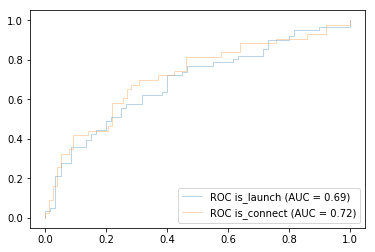

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve

def run_model(model, cv, model_name, data_dict, target_col, suppress_cols = []):
    full_X_train = data_dict['X_train']
    full_X_test = data_dict['X_test']
    full_y_train = data_dict['y_train']
    full_y_test = data_dict['y_test']
    cols = set(full_X_train.columns) - set(suppress_cols)
    X_train = full_X_train[list(cols)]
    X_test = full_X_test.reindex(columns=list(cols)).fillna(0)
    y_train = full_y_train[target_col]
    y_test = full_y_test[target_col]
    cv_results = cross_validate(model, X_train, y_train, cv=cv, return_estimator=True, n_jobs=-1)
    best_index = max((v, i) for i, v in enumerate(cv_results['test_score']))[1]
    best_model = cv_results['estimator'][best_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    print('Accuracy of', target_col, model_name, 'classifier on test set: {:.2f}'
          .format(best_model.score(X_test, y_test)))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    probas_ = best_model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC {target_col} (AUC = %0.2f)' % (roc_auc))
    plt.legend(loc="lower right")

    
def run_lr(data_dict, target_col, suppress_cols = []):
    logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
    run_model(logreg, 10, 'logistic regression', data_dict, target_col, suppress_cols)
    
def run_rf(data_dict, target_col, suppress_cols = []):
    run_model(RandomForestClassifier(n_estimators=500), 10, 'random forest', data_dict, target_col, suppress_cols)
    
datasets = get_train_test(data, ['is_launch', 'is_connect'])
scaled_datasets = scale_data(datasets, ['campaign_length', 'daily_budget'])
run_lr(scaled_datasets, 'is_launch', ['text'])
run_lr(scaled_datasets, 'is_connect', ['text'])

## Process tweet text
- Remove non-ascii, hashtags, @ mentions, urls.
- Remove common words
- Remove words which only appear once.

In [0]:
import gensim
import string
def process_doc(str):
    def should_suppress(s):
        return s.startswith('#') or s.startswith('@') or s.startswith('http') or s.startswith('&amp;')
    cleaned = str.lower().split()
    # remove hashtags, @users, urls:
    cleaned = [word for word in cleaned if not should_suppress(word)]
    # Remove punctuation
    def strip_non_ascii(s):
        return ''.join(c for c in s if 0 < ord(c) < 127)
    cleaned = [strip_non_ascii(word).translate(str.maketrans('', '', string.punctuation)) for word in cleaned]
    return cleaned
    
# Create a set of frequent words
stoplist = set('for a of the and to in'.split(' '))
# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in process_doc(document) if word not in stoplist]
         for document in scaled_datasets['X_train']['text']]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]

In [0]:
processed_corpus

[['unlimited',
  'storage',
  'unlimited',
  'learn',
  'more',
  'at',
  'available',
  'at'],
 ['if', 'it', 'aint', 'dont', 'it', 'if', 'it', 'is'],
 ['grab', 'your', 'your', 'gym', 'buddy', 'rest', 'squad'],
 ['heres',
  'how',
  'is',
  'helping',
  'cities',
  'go',
  'speed',
  'up',
  'public',
  'projects',
  'more'],
 ['what',
  'makes',
  'your',
  '',
  '',
  'tweet',
  'your',
  'pups',
  'best',
  'quality',
  'well',
  'donate',
  '1'],
 ['you', 'could', 'go', 'from', 'your', 'home', 'house', 'at', 'rules'],
 [],
 ['we',
  'see',
  'what',
  'you',
  'did',
  'there',
  'now',
  'see',
  'what',
  'google',
  'assistant',
  'can',
  'do',
  'when',
  'you',
  'say',
  ''],
 ['dog', 'or', ''],
 ['when',
  'you',
  'have',
  'pack',
  'light',
  'surface',
  'go',
  'wont',
  'weigh',
  'you',
  'down',
  'portable',
  'powerful',
  'starts',
  'at',
  '399'],
 ['lean',
  'cuisine',
  'has',
  'always',
  'been',
  'women',
  'now',
  'were',
  'helping',
  'women',
  'expl

## Create TF/IDF model

In [0]:
from gensim import corpora
from gensim import models

dictionary = corpora.Dictionary(processed_corpus)
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

# train the model
tfidf = models.TfidfModel(bow_corpus)

### Replace text with features consisting of TF/IDF scores
Because th

In [0]:
def replace_text_with_features(df):
    text_vec_df = pd.DataFrame()
    text_vec_df['text_vec'] = df['text'].apply(lambda text: tfidf[dictionary.doc2bow(process_doc(text))])
    d_list = []
    for index, row in text_vec_df.iterrows():
        sublist = {'id': index}
        for (key, value) in row['text_vec']:
            sublist[f'text_vec_{key}'] = value
        d_list.append(sublist)
    df2 = pd.DataFrame(d_list).fillna(0)
    df2 = df2.set_index('id')
    return pd.concat([df, df2], axis=1, join='inner')

text_feature_datasets = scaled_datasets.copy()
text_feature_datasets['X_train'] = replace_text_with_features(scaled_datasets['X_train'])
text_feature_datasets['X_test'] = replace_text_with_features(scaled_datasets['X_test'])

Accuracy of is_launch logistic regression classifier on test set: 0.73
[[43 17]
 [16 45]]
              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72        60
         1.0       0.73      0.74      0.73        61

   micro avg       0.73      0.73      0.73       121
   macro avg       0.73      0.73      0.73       121
weighted avg       0.73      0.73      0.73       121

Accuracy of is_connect logistic regression classifier on test set: 0.75
[[71  7]
 [23 20]]
              precision    recall  f1-score   support

         0.0       0.76      0.91      0.83        78
         1.0       0.74      0.47      0.57        43

   micro avg       0.75      0.75      0.75       121
   macro avg       0.75      0.69      0.70       121
weighted avg       0.75      0.75      0.74       121



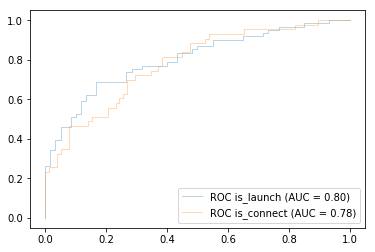

In [0]:
run_lr(text_feature_datasets, 'is_launch', ['text'])
run_lr(text_feature_datasets, 'is_connect', ['text'])

Accuracy of is_launch random forest classifier on test set: 0.77
[[49 11]
 [17 44]]
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78        60
         1.0       0.80      0.72      0.76        61

   micro avg       0.77      0.77      0.77       121
   macro avg       0.77      0.77      0.77       121
weighted avg       0.77      0.77      0.77       121

Accuracy of is_connect random forest classifier on test set: 0.75
[[68 10]
 [20 23]]
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82        78
         1.0       0.70      0.53      0.61        43

   micro avg       0.75      0.75      0.75       121
   macro avg       0.73      0.70      0.71       121
weighted avg       0.75      0.75      0.74       121



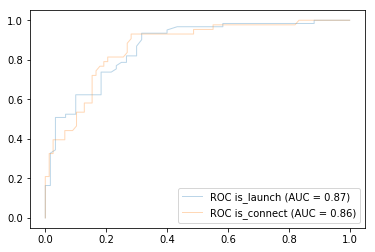

In [0]:
run_rf(text_feature_datasets, 'is_launch', ['text'])
run_rf(text_feature_datasets, 'is_connect', ['text'])

# Using the keywords from ML_JTBD_shared

In [0]:
#List of launch keywords that hint towards a launch tweet categorized into
low_launch_keyword_list = ['about to','get a','just got','latest','on Amazon','on Netflix','only on','reveal','right now','season','stream']
medium_launch_keyword_list = ['are here','are now','are on','boards','brand new','buy now','prepare for','start your','the new']
high_launch_keyword_list = ['all new','all-new','alpha','april','aug','beginning','beta','check it out','check out','check out the new','coming soon','debut','december','ever before','exclusively','feb','first ever','fri','introducing','is back','is here','is live','is now','is on','isback','jan','july','june','launch','live now','monday','new','new feature','nov','now available','now on','now online','now only','now playing','oct','offer','online now','out now','play now','pre order','pre-order','premier','presenting','presents','saturday','sept','special rate','sunday','this week','this year','thur','today','tues','we are now','wednesday']

In [0]:
# Create a new column to calculate the launch keyword count in tweet text
import copy
scaled_datasets_text = copy.deepcopy(scaled_datasets)
for word in low_launch_keyword_list + medium_launch_keyword_list + high_launch_keyword_list:
    train = scaled_datasets_text['X_train']
    train[word.replace(' ', '_')]=train['text'].apply(lambda x: 1 if word in x else 0)
    test = scaled_datasets_text['X_test']
    test[word.replace(' ', '_')]=test['text'].apply(lambda x: 1 if word in x else 0)
scaled_datasets_text['X_train'].drop(columns=['text'], inplace=True)
scaled_datasets_text['X_test'].drop(columns=['text'], inplace=True)

## Dimensionsity reduction

In [0]:
scaled_datasets_pca = copy.deepcopy(scaled_datasets_text)
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
pca.fit(scaled_datasets_text['X_train'])
scaled_datasets_pca['X_train'] = pca.transform(scaled_datasets_text['X_train'])
scaled_datasets_pca['X_test'] = pca.transform(scaled_datasets_text['X_test'])

Accuracy of is_launch gdbt classifier on test set: 0.76
[[50 10]
 [19 42]]
              precision    recall  f1-score   support

         0.0       0.72      0.83      0.78        60
         1.0       0.81      0.69      0.74        61

   micro avg       0.76      0.76      0.76       121
   macro avg       0.77      0.76      0.76       121
weighted avg       0.77      0.76      0.76       121

Accuracy of is_connect gdbt classifier on test set: 0.81
[[64 14]
 [ 9 34]]
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85        78
         1.0       0.71      0.79      0.75        43

   micro avg       0.81      0.81      0.81       121
   macro avg       0.79      0.81      0.80       121
weighted avg       0.82      0.81      0.81       121



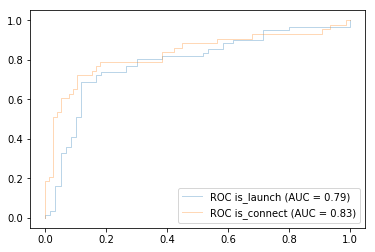

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
def run_gbdt(target_col):
    X_train = scaled_datasets_pca['X_train']
    X_test = scaled_datasets_pca['X_test']
    y_train = scaled_datasets_pca['y_train'][target_col]
    y_test = scaled_datasets_pca['y_test'][target_col]
    cv_results = cross_validate(GradientBoostingClassifier(n_estimators=1000),
                                X_train, y_train, cv=10, return_estimator=True)
    best_index = max((v, i) for i, v in enumerate(cv_results['test_score']))[1]
    best_model = cv_results['estimator'][best_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    print('Accuracy of', target_col, 'gdbt classifier on test set: {:.2f}'
          .format(best_model.score(X_test, y_test)))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    probas_ = best_model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC {target_col} (AUC = %0.2f)' % (roc_auc))
    plt.legend(loc="lower right")
run_gbdt('is_launch')
run_gbdt('is_connect')

### Incomplete: Attempt using word2vec.
Need to use a pre-trained word model because we don't have enough data to learn embeddings for words.

In [0]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [0]:
w2v_model.most_similar('january')

[('february', 0.7155449390411377),
 ('september', 0.7122892737388611),
 ('november', 0.7052292823791504),
 ('april', 0.692517101764679),
 ('december', 0.6702613830566406),
 ('july', 0.6697752475738525),
 ('october', 0.6633804440498352),
 ('feb', 0.6114217042922974),
 ('june', 0.6087075471878052),
 ('os', 0.5675598382949829)]